# Project 4: Candidate Resume Recommendation System
# Import packages

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, DBSCAN
import pyLDAvis
import pyLDAvis.sklearn
import statistics 
import matplotlib.pyplot as plt
import seaborn as sns
import umap

/Users/hellojenny/opt/anaconda3/envs/metis/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [2]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

/Users/hellojenny/opt/anaconda3/envs/metis/lib/python3.7/site-packages/thinc/neural/train.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from .optimizers import Adam, SGD, linear_decay
/Users/hellojenny/opt/anaconda3/envs/metis/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable
/Users/hellojenny/opt/anaconda3/envs/metis/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable
/Users/hellojenny/opt/anaconda3/en

# Load the data into dataframes

In [3]:
jobs = pd.read_pickle('./jobs_cleaned.pkl')
resumes = pd.read_pickle('./resumes_cleaned.pkl')

/Users/hellojenny/opt/anaconda3/envs/metis/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
/Users/hellojenny/opt/anaconda3/envs/metis/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping


# Conduct Additional EDA
Since there are only 2,000 rows of resumes and a lot of them have very little text after pre-processing, i.e., less than 20 words. I'll be cutting down the data to only include more than 23 words, as it will reserve at least 1,000 resumes for the recommendation engine.

(array([1981.,  228.,  106.,   52.,   26.,   12.,    4.,    3.,    2.,
           2.]),
 array([1.0000e+00, 7.0750e+02, 1.4140e+03, 2.1205e+03, 2.8270e+03,
        3.5335e+03, 4.2400e+03, 4.9465e+03, 5.6530e+03, 6.3595e+03,
        7.0660e+03]),
 <a list of 10 Patch objects>)

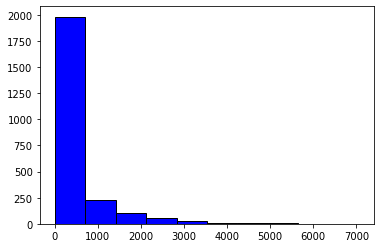

In [4]:
statistics.mode([len(text) for text in resumes['text']])
dist = [len(text) for text in resumes['text']]
plt.hist(dist, color = 'blue', edgecolor = 'black')

In [5]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [6]:
X = [[len(text.split()), two] for text in resumes['text'] for two in [2]]
X = np.asarray(X)
X

array([[ 27,   2],
       [ 20,   2],
       [ 24,   2],
       ...,
       [108,   2],
       [206,   2],
       [302,   2]])

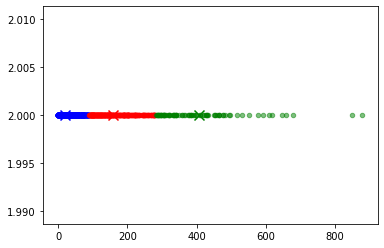

In [7]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=10) # n_init, number of times the K-mean algorithm will run
km.fit(X)
display_cluster(X,km,num_clusters)

In [8]:
count = 0
for text in resumes['text']:
    if len(text.split()) > 23:
        count+=1
count

1007

In [9]:
def num_words(text):
    return len(text.split())

resumes = resumes[resumes['text'].map(num_words) >= 23] 

In [10]:
resumes.reset_index(inplace=True)

In [11]:
resumes.drop(['index'], axis=1, inplace=True)

In [12]:
resumes

,applicant_id,job_title,job_description,cleaned_job_title,cleaned_job_description,text
0,2,Writer for the Uloop Blog Volunteer,"* Wrote articles for the ""Uloop Blog,"" which i...",writer uloop blog volunteer,read aloud book record audio visually impair w...,writer uloop blog volunteer read aloud book re...
1,78,Impact team member,"Help maintain merchandise flow, Work on fillin...",impact team member,help maintain merchandise flow fill present st...,impact team member help maintain merchandise f...
2,89,Clerk's helper Healthcare Specialist / Combat ...,"Clinical and field medicine, Healthcare educat...",clerk helper healthcare specialist combat medic,clinical field medicine education food medicin...,clerk helper healthcare specialist combat medi...
3,96,Receptionist Cashier Cashiet/Waiter,"Place table for customers, provide water or te...",cashier cashiet waiter receptionist,place table customer provide water tea sit tak...,cashier cashiet waiter receptionist place tabl...
4,153,Banker Photographer Front Desk Agent Operatio...,•\tCaptured memories and experiences for famil...,photographer front desk agent banker operation...,exceed monthly quarterly goal proactively sell...,photographer front desk agent banker operation...
...,...,...,...,...,...,...
1029,14617,Technical Sales Associate Volunteer Member Pre...,•\tEnhanced knowledge about health topics such...,member president volunteer uci health certifie...,promoted awareness eating disorder organize ev...,member president volunteer uci health certifie...
1030,14622,"Account Manager Manager, Digital Sales Plannin...",●\tGenerate digital media plans for InStyle.co...,account manager digital sales account manager ...,pre sale post sale duty agency client account ...,account manager digital sales account manager ...
1031,14639,Student Senate Intern Girl Boss Consultant Tou...,"Strategy and operations consulting, primarily ...",assistant property manager webmaster consultan...,responsible lead historical informational min...,assistant property manager webmaster consultan...
1032,14642,Director Diversity & Human Resources Adjunct F...,*Chief Human Resources Officer and Director of...,found president author director diversity huma...,connect scholar industry expert manager educa...,found president author director diversity huma...


# Vectorizer

Fit the vectorizer on `Resume`

In [13]:
tfidf = TfidfVectorizer(ngram_range=(2,3), 
                        stop_words='english', 
                        sublinear_tf=True,
                        min_df=12, 
                        max_df=0.7)
doc_word = tfidf.fit_transform(resumes['text'])
doc_word.shape

(1034, 192)

# Dimension Reduction

In [14]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix+1)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [15]:
component_count = 8
component_names = [f'Topic {component_num+1}' for component_num in range(component_count)]

## LSA

In [16]:
lsa = TruncatedSVD(component_count)
doc_topic = lsa.fit_transform(doc_word)

topic_word = pd.DataFrame(lsa.components_.round(3), 
                          index=component_names,
                          columns=tfidf.get_feature_names())

resume_doc_topic_lsa = pd.DataFrame(doc_topic.round(5), 
                                    index=resumes['text'], 
                                    columns = component_names)

print('Total Explained Variance Ratio:', lsa.explained_variance_ratio_.sum())

Total Explained Variance Ratio: 0.13921468080769134


In [17]:
display_topics(lsa, tfidf.get_feature_names(), 10)


Topic  1
customer service, sale associate, service representative, excellent customer, excellent customer service, cash register, customer service representative, train new, assist customer, social medium

Topic  2
social medium, administrative assistant, team member, day day, datum entry, business development, policy procedure, new employee, train new, sale associate

Topic  3
sale associate, cash register, answer phone, greet customer, answer question, help customer, train new, new employee, train new employee, datum entry

Topic  4
sale associate, social medium, help customer, business development, marketing strategy, real estate, sale marketing, team member, new business, marketing campaign

Topic  5
train new, new employee, train new employee, team member, account manager, cash register, excellent customer service, excellent customer, training new, human resources

Topic  6
social medium, train new, answer phone, new employee, train new employee, answer question, excellent custom

**Explained Variance**

Text(0, 1.03, 'Cumulative \n Explained Variance')

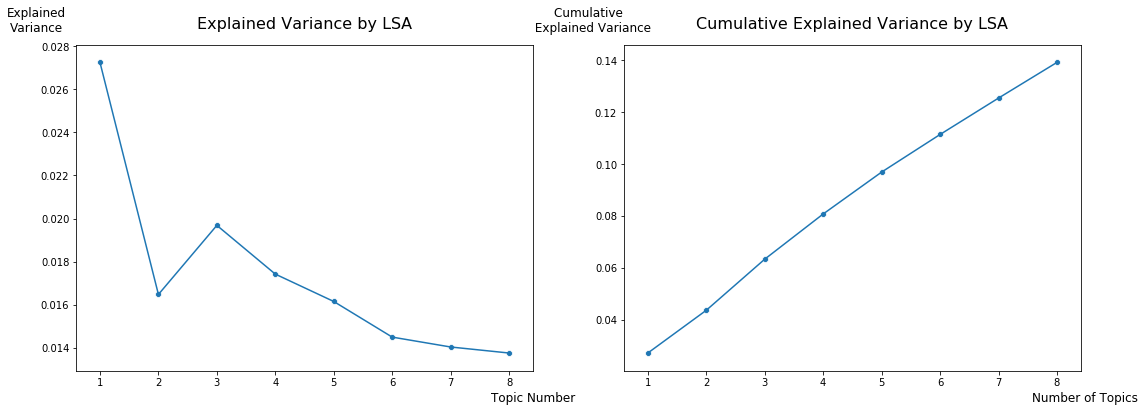

In [18]:
var_ratio = lsa.explained_variance_ratio_
num_components = [i+1 for i in range(len(var_ratio))]

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.lineplot(num_components, var_ratio)
sns.scatterplot(num_components, var_ratio)
plt.title('Explained Variance by LSA', fontsize=16, y= 1.03)
plt.xlabel('Topic Number', fontsize = 12, x=1.0)
plt.ylabel('Explained\nVariance', fontsize = 12, y=1.03, rotation=0)

plt.subplot(1, 2, 2)
cum_variance = np.cumsum(var_ratio)
sns.lineplot(num_components, cum_variance)
sns.scatterplot(num_components, cum_variance)
plt.title('Cumulative Explained Variance by LSA', fontsize=16, y= 1.03)
plt.xlabel('Number of Topics', fontsize = 12, x=1.01)
plt.ylabel('Cumulative \n Explained Variance', fontsize = 12, y=1.03, rotation=0)
# plt.savefig('./img/variance_per_component_lsa.png', bbox_inches = 'tight')

## NMF

In [19]:
nmf = NMF(component_count, random_state=42)
doc_topic = nmf.fit_transform(doc_word)

topic_word = pd.DataFrame(nmf.components_.round(3),
                          index = component_names,
                          columns = tfidf.get_feature_names())

resume_doc_topic_nmf = pd.DataFrame(doc_topic.round(5), 
                                    index=resumes['text'], 
                                    columns = component_names)

In [20]:
display_topics(nmf, tfidf.get_feature_names(), 10)


Topic  1
customer service, service representative, customer service representative, provide customer, provide customer service, assist customer, resolve customer, fast pace, open close, service skill

Topic  2
team member, policy procedure, business development, project manager, new business, responsibility include, day day, credit card, sale team, account manager

Topic  3
sale associate, help customer, cash register, greet customer, sale floor, provide customer, cash drawer, provide customer service, customer need, service customer

Topic  4
answer phone, administrative assistant, datum entry, data entry, line phone, clerical duty, multi line, order supply, travel arrangement, duty include

Topic  5
train new, new employee, train new employee, human resources, training new, executive assistant, inbound outbound, cash register, administrative support, service representative

Topic  6
social medium, marketing strategy, press release, act liaison, marketing campaign, small business, sp

## LDA

In [23]:
lda = LatentDirichletAllocation(n_components=component_count, # Number of topics
                                learning_method = 'online',
                                random_state=0,       
                                n_jobs = -1)  # Use all available CPUs

doc_topic = lda.fit_transform(doc_word)

topic_word = pd.DataFrame(lda.components_.round(3),
                          index = component_names,
                          columns = tfidf.get_feature_names())

resume_doc_topic_lda = pd.DataFrame(doc_topic.round(5), 
                                    index=resumes['text'], 
                                    columns = component_names)
#resume_doc_topic_lda

In [24]:
display_topics(lda, tfidf.get_feature_names(), 10)


Topic  1
customer service, technical support, quality assurance, fast pace, security guard, high quality, sale representative, customer support, customer relation, provide customer

Topic  2
customer service, human resources, responsibility include, data entry, security officer, policy procedure, credit card, service representative, daily activity, customer service representative

Topic  3
sale associate, customer service, answer question, make sure, cash register, excellent customer, excellent customer service, assist customer, provide customer, provide excellent

Topic  4
software engineer, sale goal, train new, phone email, manager manage, day operation, day day operation, hardware software, customer relation, increase sale

Topic  5
project include, public relation, administrative duty, high school, timely manner, travel arrangement, duty include, office assistant, assistant manager, press release

Topic  6
social medium, business development, financial service, service client, pr

## Plots
### Intertopic Distance Map

In [25]:
lda_vis = pyLDAvis.sklearn.prepare(lda, doc_word, tfidf, mds='tsne', R=10)

In [26]:
print(f'\n')
pyLDAvis.enable_notebook()

lda_vis

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5     -108.958252 -208.941483       1        1  19.283764
2      186.487061  -98.103249       2        1  16.192013
6       19.245832  160.858780       3        1  15.494517
1      170.658829   75.445076       4        1  12.525503
0       -1.386411  -35.043739       5        1   9.968122
7     -145.800095  106.944611       6        1   9.265570
4       64.834541 -221.825272       7        1   9.027182
3     -196.906036  -58.990913       8        1   8.243329, topic_info=                    Term       Freq      Total Category  logprob  loglift
51     develop implement  20.000000  20.000000  Default  10.0000  10.0000
40      customer service  67.000000  67.000000  Default   9.0000   9.0000
133      project include  16.000000  16.000000  Default   8.0000   8.0000
56          duty include  20.000000  20.000000  Default   7.0000   7.0000
80       human resources  17.000000  17.000000  Default   6.0000   6.0000
..                   ...        ...        ...      ...      ...      ...
68       general manager   4.487063   6.625584   Topic8  -3.4728   2.1060
84         increase sale   5.254336   7.840701   Topic8  -3.3149   2.0955
24   communication skill   4.486108   7.107380   Topic8  -3.4730   2.0356
38     customer relation   5.380833  10.256205   Topic8  -3.2912   1.8507
184            train new   6.813686  17.444622   Topic8  -3.0551   1.5557

[121 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
0         3  0.145737   account executive
0         5  0.145737   account executive
0         6  0.582950   account executive
1         1  0.244909     account manager
1         3  0.673499     account manager
...     ...       ...                 ...
187       1  0.297983    training program
187       7  0.595966    training program
188       7  0.861640  travel arrangement
189       1  0.913176      vice president
191       6  0.670900      weekly monthly

[195 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 7, 2, 1, 8, 5, 4])

In [25]:
##pyLDAvis.show(lda_vis)

### UMAP Plot

**LDA UMAP based on Euclidean Distance**

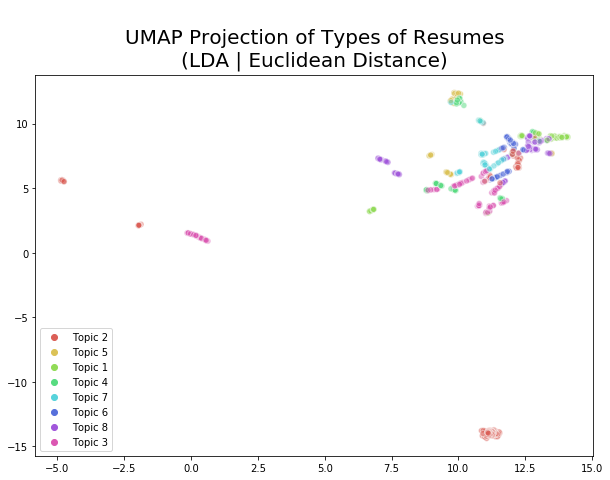

In [26]:
## Kmean Clustering for labels
num_clusters = 8
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1000) # n_init, number of times the K-mean algorithm will run
km.fit(resume_doc_topic_lda)
km.cluster_centers_
km_labels = km.labels_ + 1 # topic 1 ~ 8 instead of 0 ~ 7
labels = []
for label in km_labels:
    labels.append("Topic " + str(label))
    
## UMAP
reducer_euclidean = umap.UMAP(random_state = 42, n_components = 8)
reducer_euclidean.fit(resume_doc_topic_lda.values)
embeddings_euclidean = reducer_euclidean.transform(resume_doc_topic_lda.values)

## Plot
plt.figure(figsize=(10, 7))

sns.scatterplot(embeddings_euclidean[:, 0], 
                embeddings_euclidean[:, 1], 
                hue = labels,
                legend = 'full',
                palette = sns.color_palette("hls", 8),
                alpha = 0.5)

plt.title(f'\nUMAP Projection of Types of Resumes\n(LDA | Euclidean Distance)', fontsize = 20, y = 1.01);

**NMF UMAP based on Cosine Similarity**

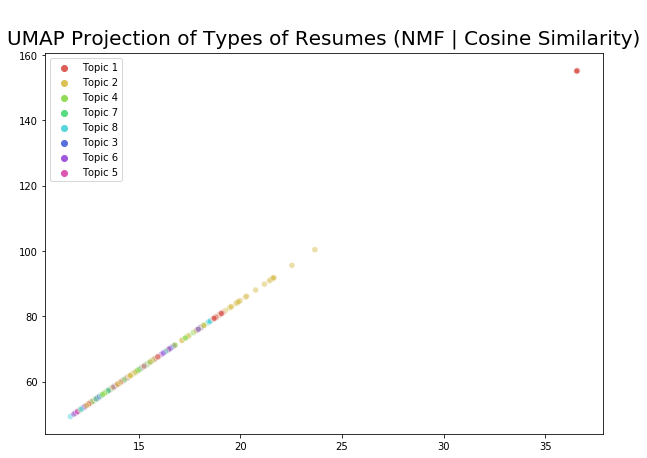

In [27]:
## labels are the topic number with the max value
labels = resume_doc_topic_nmf.idxmax(axis=1).tolist()

## UMAP
reducer_cosine = umap.UMAP(random_state = 42, n_components = 8, metric='cosine', output_metric='cosine')
reducer_cosine.fit(resume_doc_topic_nmf.values)
embeddings_cosine = reducer_cosine.transform(resume_doc_topic_nmf.values)

## Plot
plt.figure(figsize=(10, 7))

sns.scatterplot(embeddings_cosine[:, 0], 
                embeddings_cosine[:, 1], 
                hue = labels,
                legend = 'full',
                palette = sns.color_palette("hls", 8),
                alpha = 0.5)

plt.title(f'\nUMAP Projection of Types of Resumes (NMF | Cosine Similarity)', fontsize = 20, y = 1.01);

**LSA UMAP based on Cosine Similarity**

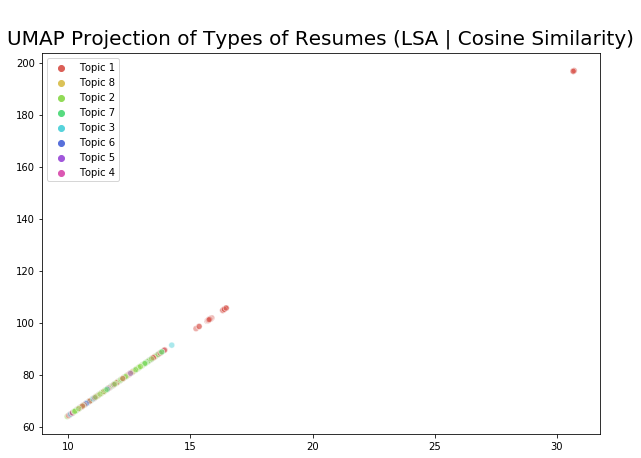

In [28]:
# labels are the topic number with the max value
labels = resume_doc_topic_lsa.idxmax(axis=1).tolist()

## UMAP
reducer_cosine = umap.UMAP(random_state = 42, n_components = 8, metric='cosine', output_metric='cosine')
reducer_cosine.fit(resume_doc_topic_lsa.values)
embeddings_cosine = reducer_cosine.transform(resume_doc_topic_lsa.values)

## Plot
plt.figure(figsize=(10, 7))

sns.scatterplot(embeddings_cosine[:, 0], 
                embeddings_cosine[:, 1], 
                hue = labels,
                legend = 'full',
                palette = sns.color_palette("hls", 8),
                alpha = 0.5)

plt.title(f'\nUMAP Projection of Types of Resumes (LSA | Cosine Similarity)', fontsize = 20, y = 1.01);

# Recommendation Engine

**Recommendation function using `pairwise_distances`**

In [29]:
def pairwise_func(text): 
    vt = tfidf.transform(sample_jd)
    tt = lsa.transform(vt)
    cos = pairwise_distances(tt,resume_doc_topic_lsa,metric='cosine').argsort()[0]
    doc_num_1 = cos[0]
    doc_num_2 = cos[1]
    print(list(cos[0:10]))
    print(resumes.iloc[doc_num_1, [2]])
    print(resumes.iloc[doc_num_2, [2]])

**Recommendation function with `np.dot`**

Below are the text cleaning functions from previous notebooks.

In [30]:
def ultimate_cleaning(text):
    doc = nlp(text)
    pos_tag_list = ['ADJ', 'ADV', 'NOUN', 'PART', 'VERB'] 
    stop_words_list = ['nbsp', 'candidate', 'now', 'work', 'professional', 'ability', 'hire', 'join', 
                       'interested', 'approximately', 'start', 'end', 'p.m.', '-PRON-']
    cleaned_text = []

    for token in doc:
        if token.pos_ in pos_tag_list\
        and token.is_stop == False\
        and token.is_alpha == True\
        and token.lemma_ not in stop_words_list:
            cleaned_text.append(token.lemma_)

    return ' '.join(cleaned_text)
                    
def title_cleaning(text):
    doc = nlp(text)
    pos_tag_list = ['ADJ', 'ADV', 'NOUN', 'PART', 'VERB', 'PROPN'] 
    stop_words_list = ['nbsp', 'candidate', 'now', 'work', 'professional', 'ability', 'hire', 'join', 
                       'interested', 'approximately', 'start', 'end', 'p.m.', '-PRON-']
    cleaned_text = []

    for token in doc:
        if token.pos_ in pos_tag_list\
        and token.is_stop == False\
        and token.is_alpha == True\
        and token.lemma_ not in stop_words_list:
            cleaned_text.append(token.lemma_)

    return ' '.join(cleaned_text)

In [31]:
def resume_recommendation(model, job_description, resume_doc_topic_matrix, num_recom=2):
    
    jd_doc_term_vector = tfidf.transform(job_description)
    jd_doc_topic_vector = model.transform(jd_doc_term_vector)
    
    recs = []
    resume_doc_count = range(resume_doc_topic_matrix.shape[0])
    
    for doc in resume_doc_count:
        cosine_simliarity_score = np.dot(jd_doc_topic_vector, resume_doc_topic_matrix[doc])
        recs.append([doc, cosine_simliarity_score])
    
    final_rec = sorted(recs, key = lambda x: x[1],reverse=True)
    doc_num_1 = final_rec[0][0]
    doc_num_2 = final_rec[1][0]
    print(resumes.iloc[doc_num_1, [2]])
    print(resumes.iloc[doc_num_2, [2]])
    return final_rec[:num_recom]

In [36]:
job_title = "Retail Sales Associate"
job_description = f"""As a Retail Sales Associate, you’ll provide exceptional customer service and have our customer’s needs in mind while helping them find products and providing answers & solutions.

You will be positive, inclusive and collaborative in helping our customers. You will also be part of a fun, team-oriented retail culture at Staples.

Provide an exceptional customer experience.
• Respond quickly and resourcefully to customer requests and concerns
• Create a positive, inviting environment for customers

• Multitask on sales responsibilities and merchandising while maintaining a neat and clean store
• Understand and use basic selling skills to engage and present solutions
• Be flexible in performing various responsibilities (i.e. cashier, returns, reserving online pick-ups, other duties as assigned)
• Customer service or cashier experience in a retail environment """

job_title = title_cleaning(job_title)
job_description = ultimate_cleaning(job_description)
sample_jd = [job_title + " " + job_description]

resume_recommendation(lsa, sample_jd, resume_doc_topic_lsa.to_numpy(), num_recom=2)

job_description    Customer service with footwear/keyholder custo...
Name: 336, dtype: object
job_description    Greeted resident at front desk,answer incoming...
Name: 517, dtype: object


[[336, array([0.4999967])], [517, array([0.39107471])]]

**Create a dataframe with recommended resume**

In [39]:
vt = tfidf.transform(jobs['text'])
tt = lsa.transform(vt)
recs = pairwise_distances(tt,resume_doc_topic_lsa,metric='cosine').argsort()

from collections import defaultdict
top_rec_app_ids = []
top_rec_app_resumes = []
top_10_rec_app_ids = []

for rec in recs:
    doc_num = rec[0]
    top_rec_app_ids.append(resumes['applicant_id'].loc[doc_num])
    top_rec_app_resumes.append(resumes['text'].loc[doc_num])
    top_10_rec_app_ids.append(list(rec[0:10]))
    
rec_dict = {'job_id': jobs['job_id'].tolist(), 
            'job_description_cleaned': jobs['text'].tolist(),
            'top_rec_app_id': top_rec_app_ids, 
            'top_rec_app_resume_cleaned': top_rec_app_resumes, 
            'top_10_rec_app_ids': top_10_rec_app_ids}
rec_df = pd.DataFrame.from_dict(rec_dict)
rec_df

,job_id,job_description_cleaned,top_rec_app_id,top_rec_app_resume_cleaned,top_10_rec_app_ids
0,111,tacolicious store open recently love taco love...,6385,office agent bartender server employee daily t...,"[461, 417, 829, 321, 269, 40, 518, 198, 163, 994]"
1,113,seek energetic dynamic chef charge grow compan...,14456,senior credit collection analyst collector rec...,"[1007, 71, 709, 819, 647, 946, 798, 185, 574, ..."
2,117,popular wine bar restaurant look experienced b...,2,writer uloop blog volunteer write article site...,"[0, 680, 681, 682, 683, 684, 685, 686, 687, 688]"
3,121,serve food drink customer manner cashier need ...,6385,office agent bartender server employee daily t...,"[461, 417, 829, 321, 269, 40, 518, 198, 163, 994]"
4,127,locate heart popular mexican place currently l...,14408,cook office assistance cook food clean store s...,"[1002, 356, 167, 58, 49, 1012, 195, 555, 468, 13]"
...,...,...,...,...,...
84085,82,njahs stand national japanese locate town curr...,9157,accoun payable star payroll office processing ...,"[668, 71, 776, 422, 277, 929, 729, 115, 316, 579]"
84086,83,line other shift available team kitchen order ...,2,writer uloop blog volunteer write article site...,"[0, 680, 681, 682, 683, 684, 685, 686, 687, 688]"
84087,84,onigilly japanese rice ball wrap seek outgoing...,13997,sr software engineer technical lead sr softwar...,"[904, 499, 482, 368, 1015, 866, 1, 173, 361, 807]"
84088,88,popular restaurant look experienced line cook ...,2,writer uloop blog volunteer write article site...,"[0, 680, 681, 682, 683, 684, 685, 686, 687, 688]"
